# Preparation

### Libraries and Data Reading

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [2]:
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')

# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
X = heart_disease.data.features
y = heart_disease.data.targets
df = pd.concat([X,y], axis=1)

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### First Approach

In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


### Cleaning the data

Rows with missing data

In [6]:
df[df.isnull().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,2
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


Let's delete these few data points to have a more concise analysis

In [7]:
df = df.dropna()

The following variables are described as categorical

In [8]:
variaveis_categoricas = ['cp', 'restecg', 'slope', 'thal', 'num']
variaveis_booleanas = ['fbs', 'exang']
print('Valores únicos das variáveis categóricas:')
for col in variaveis_categoricas+variaveis_booleanas:
    print(f'{col}\t {df[col].unique()}')

Valores únicos das variáveis categóricas:
cp	 [1 4 3 2]
restecg	 [2 0 1]
slope	 [3 2 1]
thal	 [6. 3. 7.]
num	 [0 2 1 3 4]
fbs	 [1 0]
exang	 [0 1]


Let's keep the variables on the scale to be able to cluster the data

# Clustering

In [9]:
X_std = StandardScaler().fit_transform(df.values)
PCA_2c = PCA(n_components=2)
X_pca = PCA_2c.fit_transform(X_std)

The following functions were based on the example from [scikit-learn](https://scikit-learn.org/1.5/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) and aim to perform optimally for different clustering algorithms from the library.

How to interpret the silhouette of clusters:
- Silhouette coefficients close to +1 indicate that the sample is far from neighboring clusters.
- A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters.
- Negative values indicate that these samples may have been assigned to the wrong cluster.

In [10]:
def plot_silhouette(X, cluster_labels, ax, unique_labels, n_clusters):
    """
    Plot the silhouette analysis for the given clustering labels.

    Parameters:
    - X: ndarray, input data
    - cluster_labels: array, labels assigned to the data points by the clustering algorithm
    - ax: matplotlib axis, axis for plotting
    - unique_labels: array, unique cluster labels
    - n_clusters: int, number of clusters (excluding noise)
    """
    if n_clusters < 2:
        ax.text(0.5, 0.5, "Clusters Insuficientes\npara análise de silhueta", 
                horizontalalignment='center', verticalalignment='center', fontsize=12, color='red', transform=ax.transAxes)
        ax.set_title("Plot da Silhueta indisponível")
        ax.set_xlabel("Valores do coeficiente de silhueta")
        ax.set_ylabel("Cluster label")
        ax.set_yticks([])
        ax.set_xticks([])
        print("Score de silhueta não calculada: menos de 2 clusters detectados.")
        return

    non_noise_mask = cluster_labels != -1
    silhouette_avg = silhouette_score(X[non_noise_mask], cluster_labels[non_noise_mask])
    print(f"Média do coeficiente de silhueta: {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10

    for label in unique_labels:
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == label]
        cluster_silhouette_values.sort()

        size_cluster = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        color = "lightgray" if label == -1 else cm.jet(float(label) / max(unique_labels))
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        cluster_name = "Ruído" if label == -1 else str(label)
        ax.text(-0.05, y_lower + 0.5 * size_cluster, cluster_name)
        y_lower = y_upper + 10

    ax.set_title("O gráfico de silhueta para os vários clusters")
    ax.set_xlabel("Valores do coeficiente de silhueta")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label="Média de silhueta")
    ax.legend()
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6])

For PCA, it is necessary to take into account the loss of information from dimensionality reduction pointed out in the following topic.

In [11]:
def plot_pca(X, cluster_labels, PCA_solver, ax, unique_labels, clusterer):
    """
    Plot the PCA visualization of clustered data.

    Parameters:
    - X: ndarray, input data
    - cluster_labels: array, labels assigned to the data points by the clustering algorithm
    - PCA_solver: PCA object, for dimensionality reduction
    - ax: matplotlib axis, axis for plotting
    - unique_labels: array, unique cluster labels
    - clusterer: clustering algorithm instance, for cluster centers
    """
    X_pca = PCA_solver.transform(X)
    colors = np.array(["lightgray" if label == -1 else cm.jet(float(label) / max(unique_labels)) for label in cluster_labels])
    ax.scatter(X_pca[:, 0], X_pca[:, 1], marker=".", s=100, lw=0, alpha=0.7, c=colors, edgecolor="k")

    try:
        centers = clusterer.cluster_centers_
    except AttributeError:
        centers = np.array([X[cluster_labels == i].mean(axis=0) for i in unique_labels if i != -1])

    if centers.size > 0:
        centers_pca = PCA_solver.transform(centers)
        ax.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="o", c="white", alpha=1, s=300, edgecolor="k")
        for i, c in enumerate(centers_pca):
            ax.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=100, edgecolor="k")

    ax.set_title("A visualização dos dados clusterizados")
    ax.set_xlabel("PCA componente 0")
    ax.set_ylabel("PCA componente 1")

We perform a clustering analysis taking into account various possible parameters, like a gridsearch.

In [12]:
def cluster_analysis(X, params_list, PCA_solver, cluster_algo):
    """
    Perform cluster analysis using a variety of clustering algorithms and parameters.

    Parameters:
    - X: ndarray, input data to cluster
    - params_list: list of dicts, each dict contains parameters for the clustering algorithm
    - PCA_solver: PCA object, for dimensionality reduction
    - cluster_algo: clustering algorithm class
    """
    for params in params_list:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # Initialize clustering algorithm
        clusterer = cluster_algo(**params)
        cluster_labels = clusterer.fit_predict(X)

        unique_labels = np.unique(cluster_labels)
        n_clusters = len(unique_labels[unique_labels != -1])

        if n_clusters == 0:
            print(f"Nenhum cluster detectado para os parâmetros {params}. Apenas ruído encontrado.")
            continue

        # Plot silhouette analysis
        plot_silhouette(X, cluster_labels, ax1, unique_labels, n_clusters)

        # Plot PCA visualization
        plot_pca(X, cluster_labels, PCA_solver, ax2, unique_labels, clusterer)

        plt.suptitle(f"Análise de silhueta e PCA para {cluster_algo.__name__} com parâmetros {params}", fontsize=14, fontweight="bold")
        plt.show()

## Dimensionality Reduction - PCA

To visualize and have some visual resource of the clusters, it is necessary to reduce the dimension from 14 dimensions (number of variables) to 2. Therefore, we need to analyze the consequences of this reduction.

Variância acumulada explicada por número de componentes [1-14]:
[0.26127688 0.37672564 0.46606038 0.54631887 0.6175074  0.6801608
 0.74113946 0.7977381  0.84867432 0.8893483  0.92207724 0.95235683
 0.97766508 1.        ]


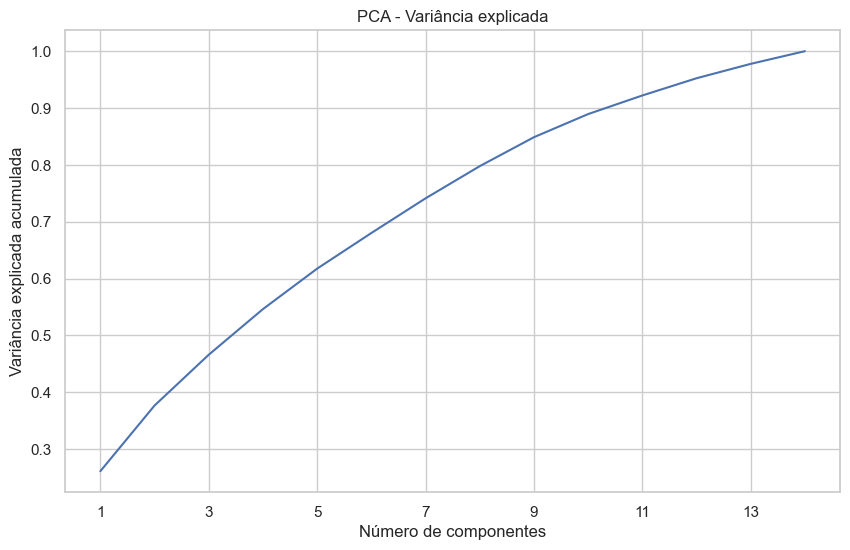

In [13]:
PCA_solver = PCA()
PCA_solver.fit_transform(X_std)

print('\033[93mVariância acumulada explicada por número de componentes [1-14]:\033[0m')
print(np.cumsum(PCA_solver.explained_variance_ratio_))

plt.figure(figsize=(10,6))
plt.plot(range(1, 15), np.cumsum(PCA_solver.explained_variance_ratio_[:14]))
plt.title('PCA - Variância explicada')
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.xticks(range(1, 15, 2))
plt.show()

The fact that each new component adds a lot of information to the reduction may be related to how distinct the variables are. In general terms, this is good, as it may mean that the variables are independent, leading to greater importance of each one. On the other hand, the cluster analysis will be impaired, as the variance explained with 2 components is only 0.37672564.

In [14]:
PCA_solver = PCA(n_components=2)
PCA_solver.fit_transform(X_std)

components = PCA_solver.components_
explained_variance_ratio = PCA_solver.explained_variance_ratio_

print('\n\033[93mVariância explicada por cada componente\033[0m')
pd.DataFrame(PCA_solver.components_, columns=df.columns)


Variância explicada por cada componente


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.237013,0.122998,0.267909,0.141442,0.067397,0.061249,0.131024,-0.345572,0.300228,0.36076,0.309104,0.297553,0.328677,0.423838
1,0.441552,-0.429378,-0.134900,0.400693,0.428286,0.241357,0.269639,0.017313,-0.179174,-0.03179,-0.038650,0.159603,-0.245694,-0.082336


For 2 components, we see that some variables stand out. In component 0, num (diagnosis) stands out, while in component 1 it is age and sex. In fact, these are variables that at first glance are very important to explain the others, as it is possible to infer many other conditions.

## K-Means

Média do coeficiente de silhueta: 0.19864840948550236


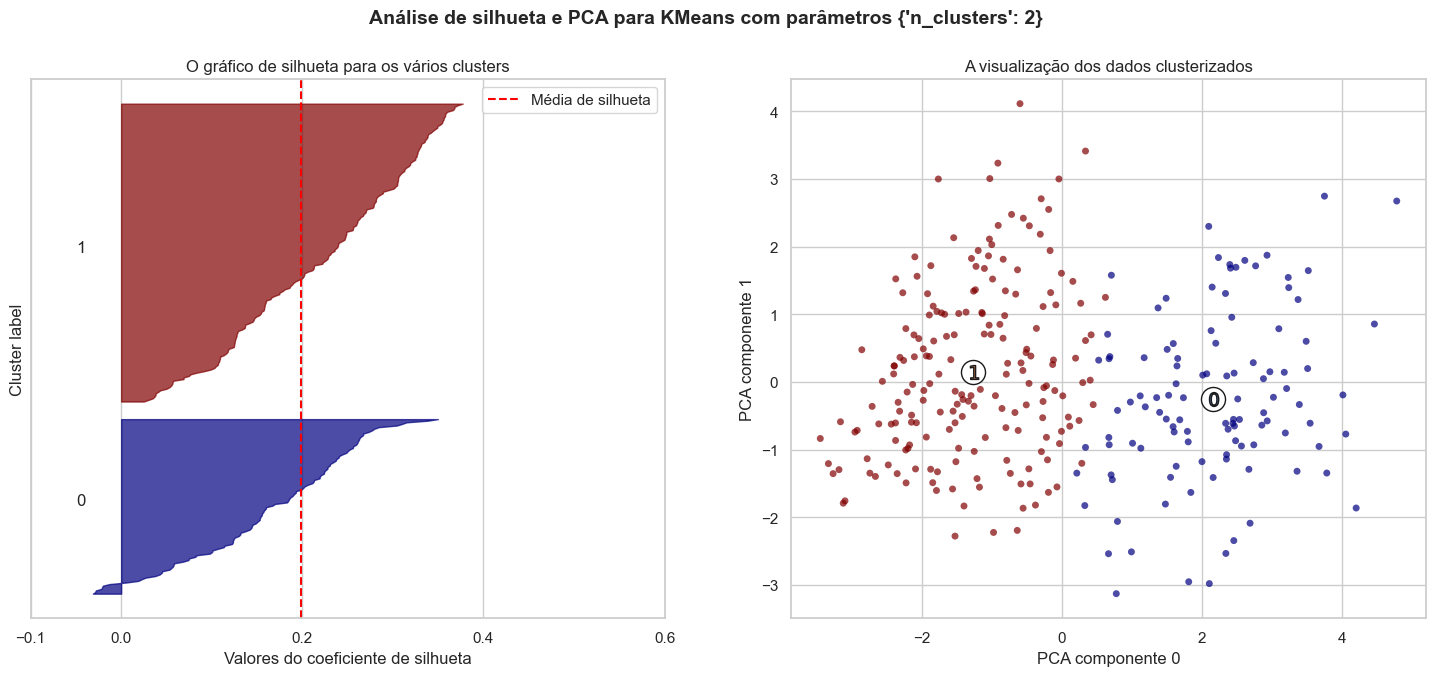

Média do coeficiente de silhueta: 0.13099922273224485


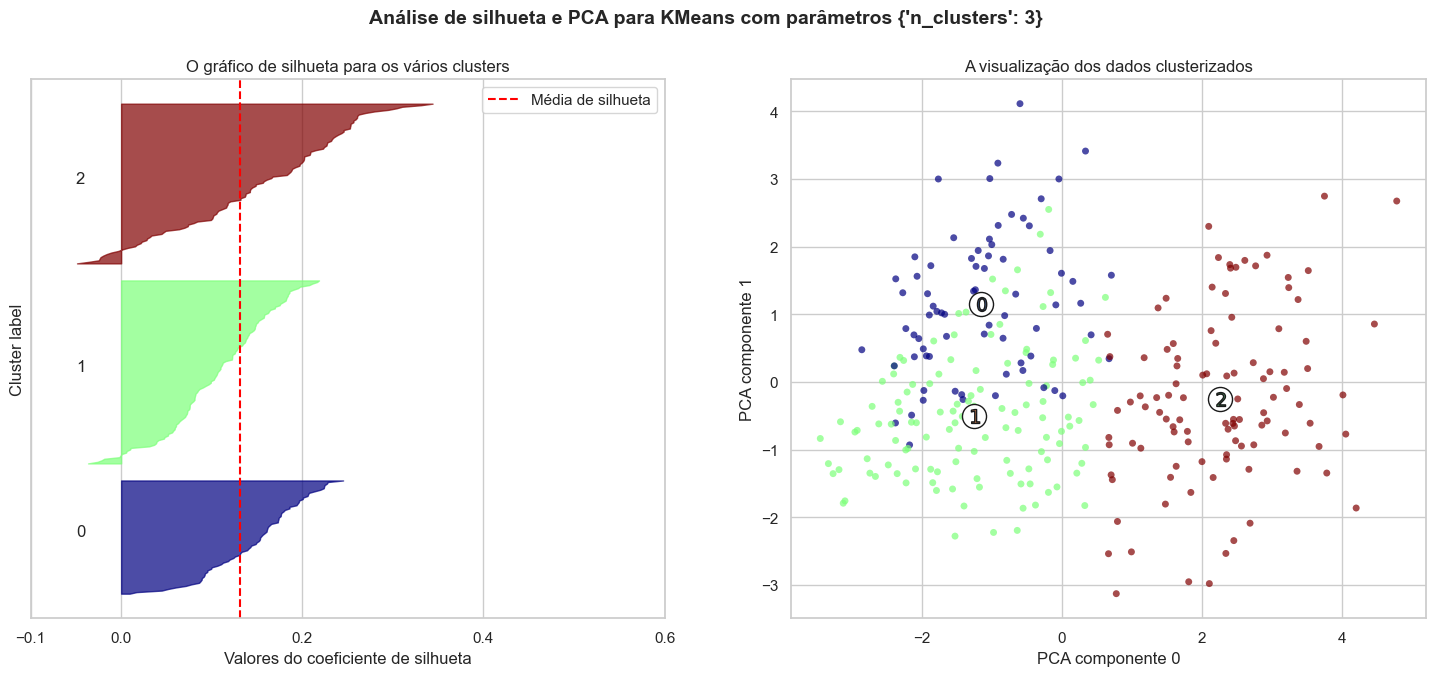

Média do coeficiente de silhueta: 0.12564264603285083


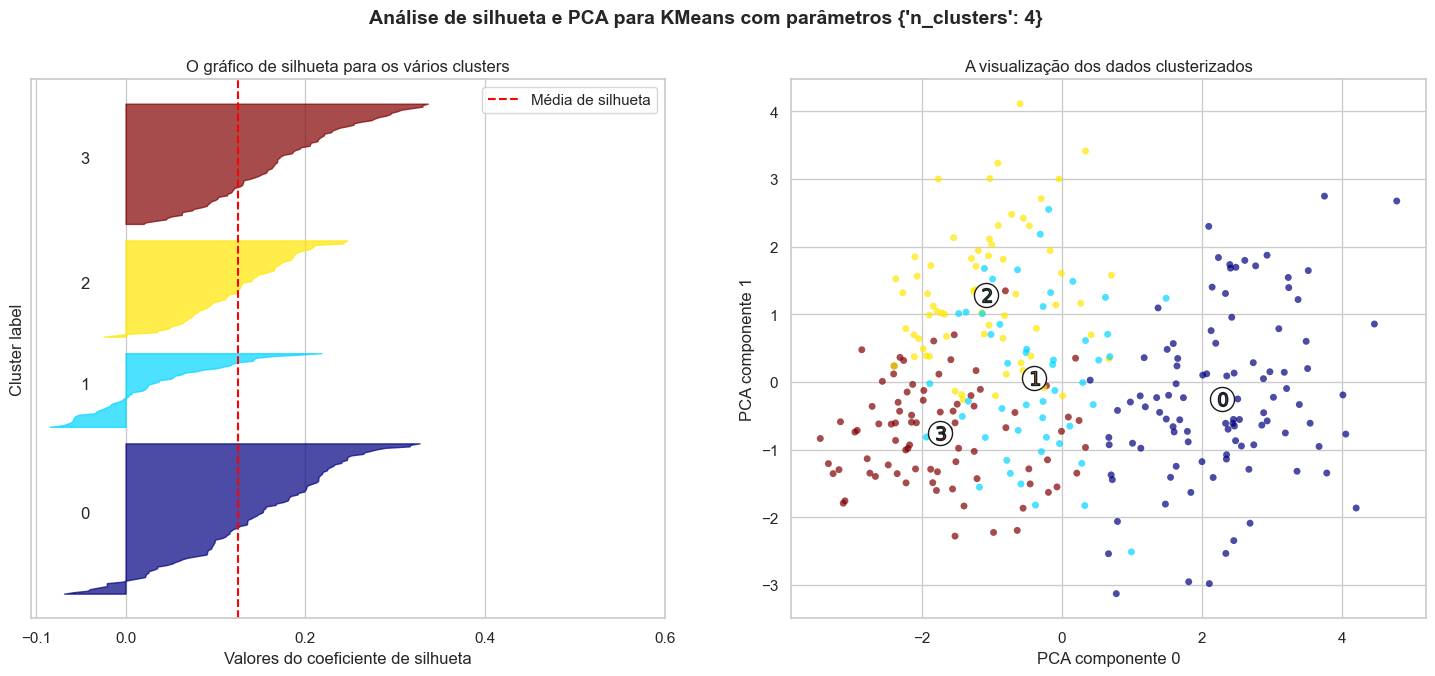

Média do coeficiente de silhueta: 0.11767942470850143


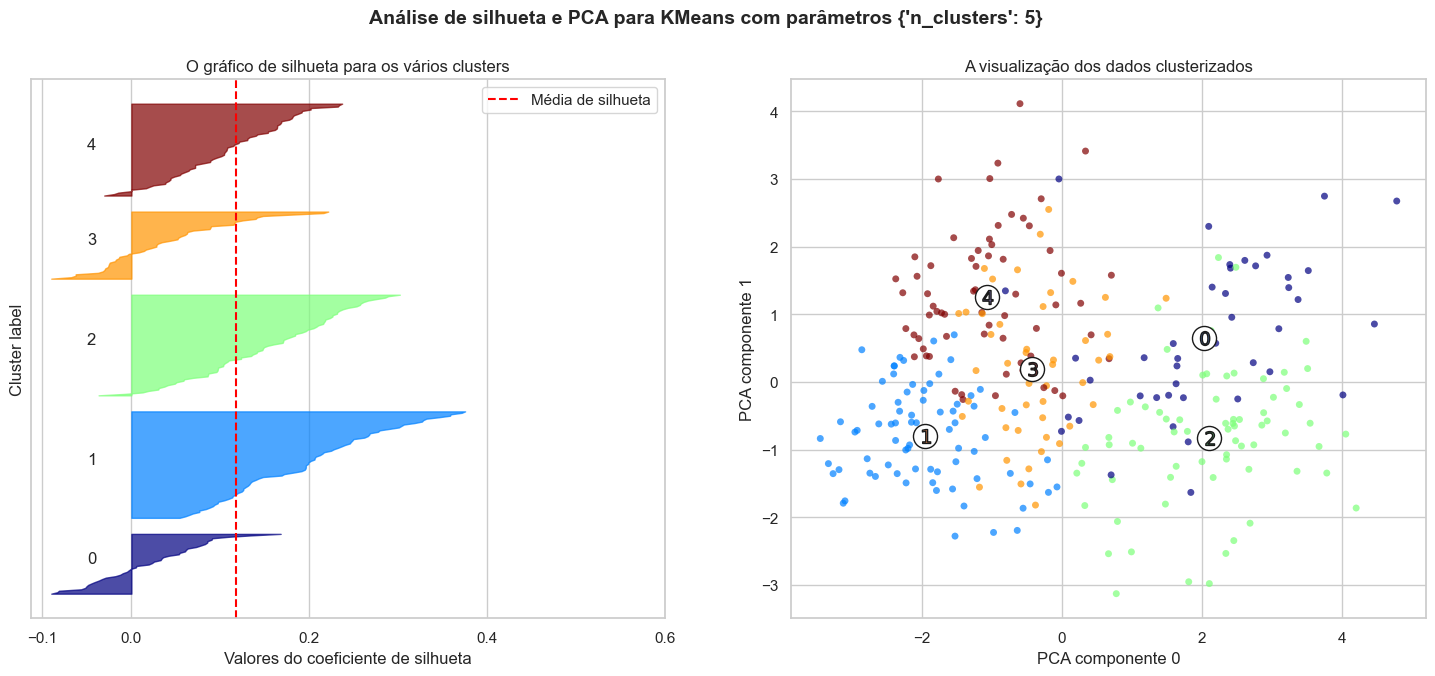

In [15]:
range_n_clusters = [2, 3, 4, 5]
range_n_clusters = [
    {"n_clusters": 2},
    {"n_clusters": 3},
    {"n_clusters": 4},
    {"n_clusters": 5},
]
cluster_analysis(
    X=X_std,
    params_list=range_n_clusters,
    PCA_solver=PCA_2c,
    cluster_algo=KMeans
)

Evaluating the average silhouette coefficient, KMeans with 2 clusters seems to generate more concise groups, something present in the 2D representation of the data, as the clouds are well defined. Additionally, as pointed out in the PCA topic, component 0 focuses mainly on the diagnosis, and we see here that this is a decisive factor for the delimitation of these 2 clusters.  
Meanwhile, in the other graphs, the representation seems more confusing, with points mixing in different clusters, perhaps taking into account other variables not as well defined in the reduction.

## DBSCAN

Média do coeficiente de silhueta: 0.36198164811972006


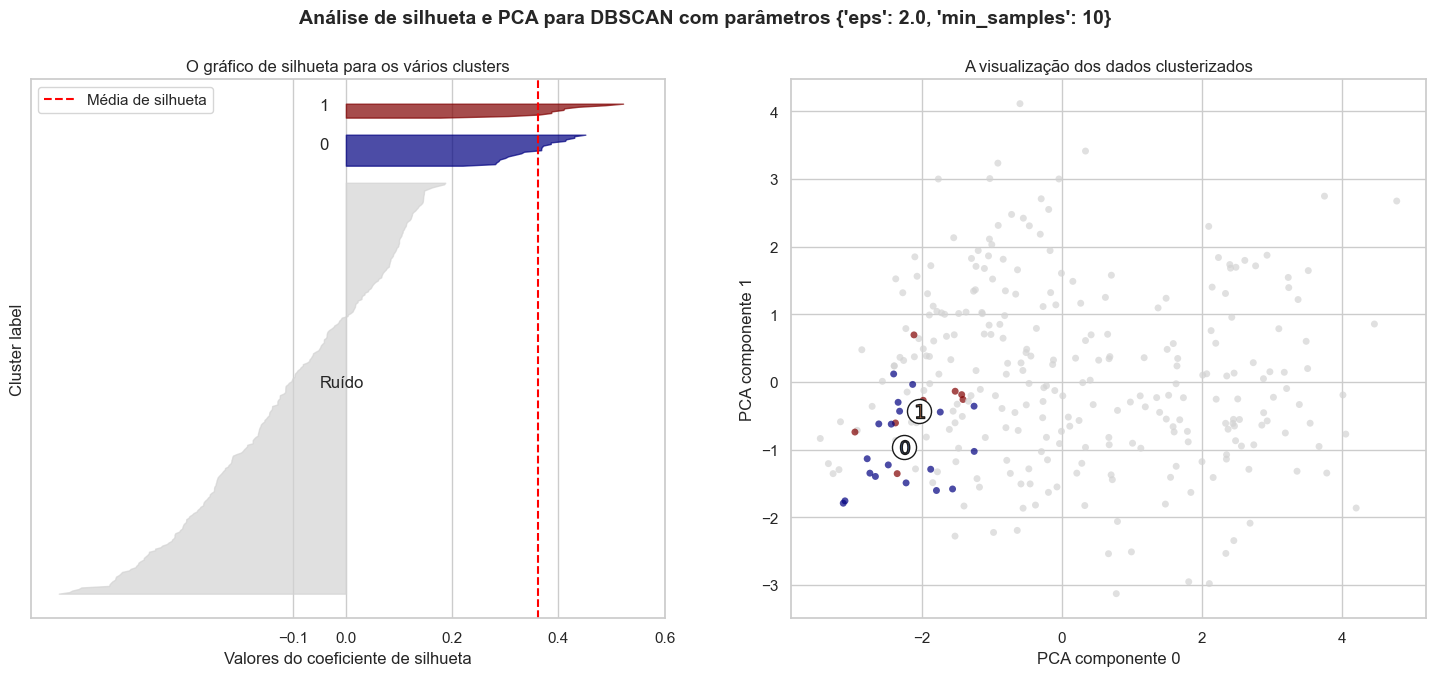

Média do coeficiente de silhueta: 0.30392904759772543


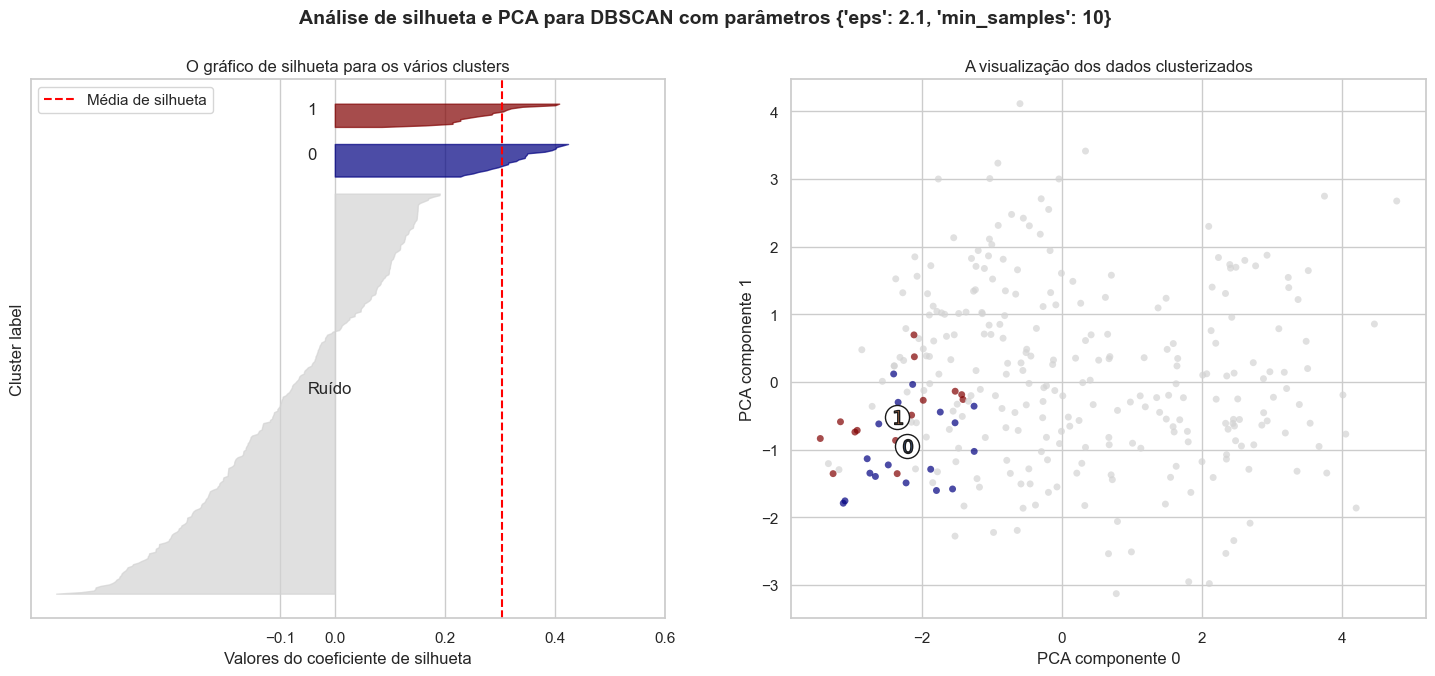

Média do coeficiente de silhueta: 0.23039886850904057


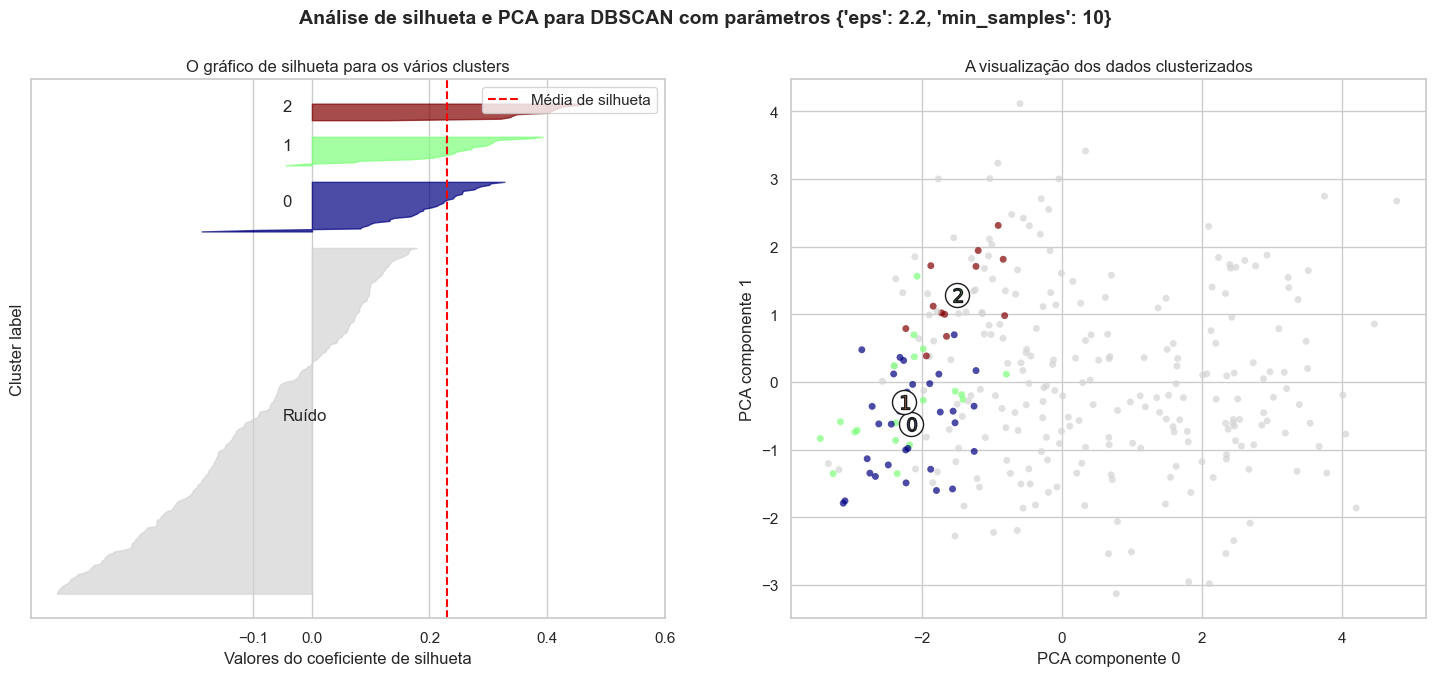

Score de silhueta não calculada: menos de 2 clusters detectados.


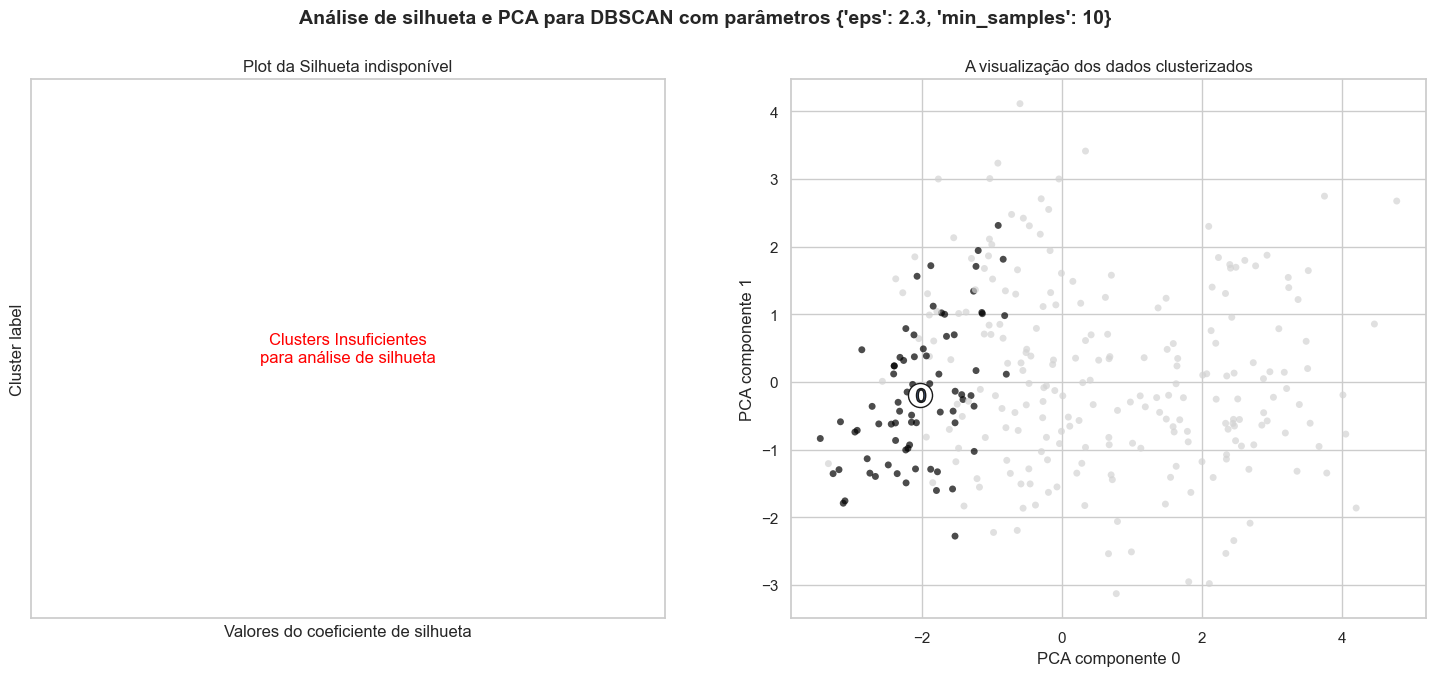

Média do coeficiente de silhueta: 0.3963857166148557


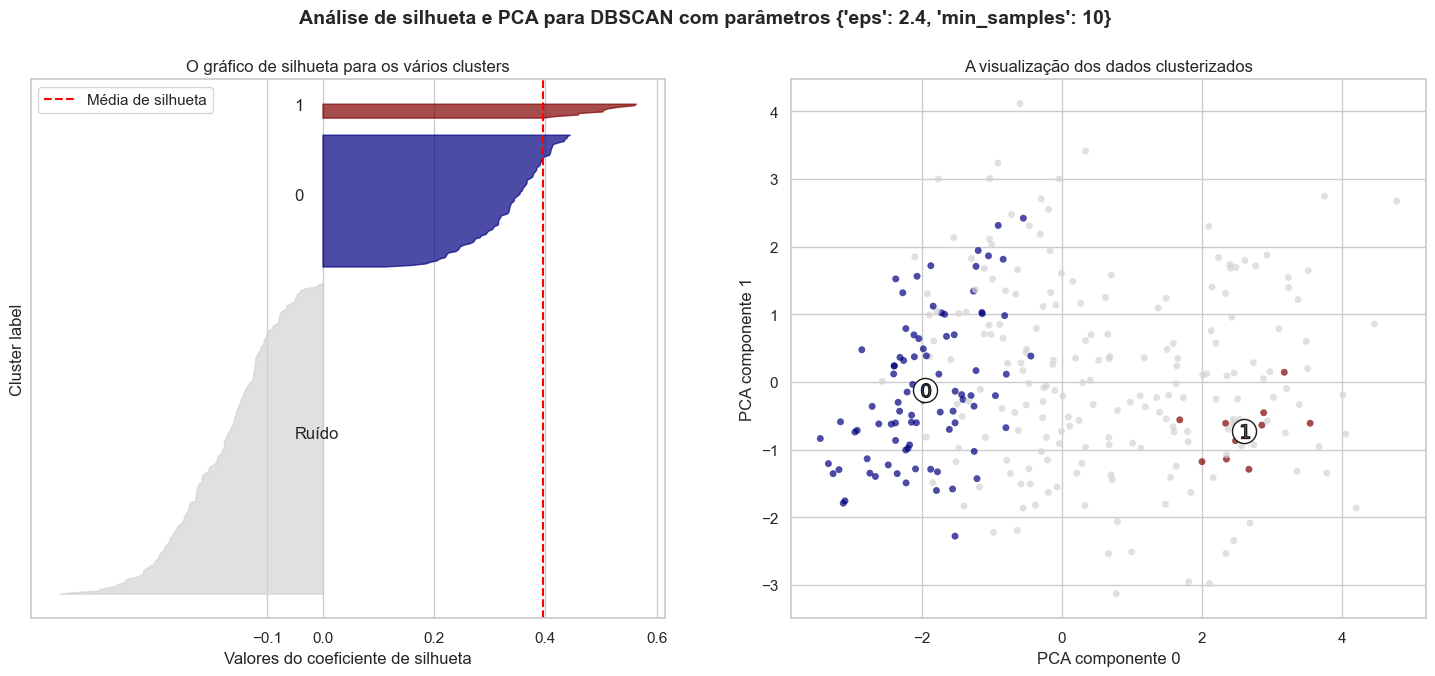

Média do coeficiente de silhueta: 0.36919122115825026


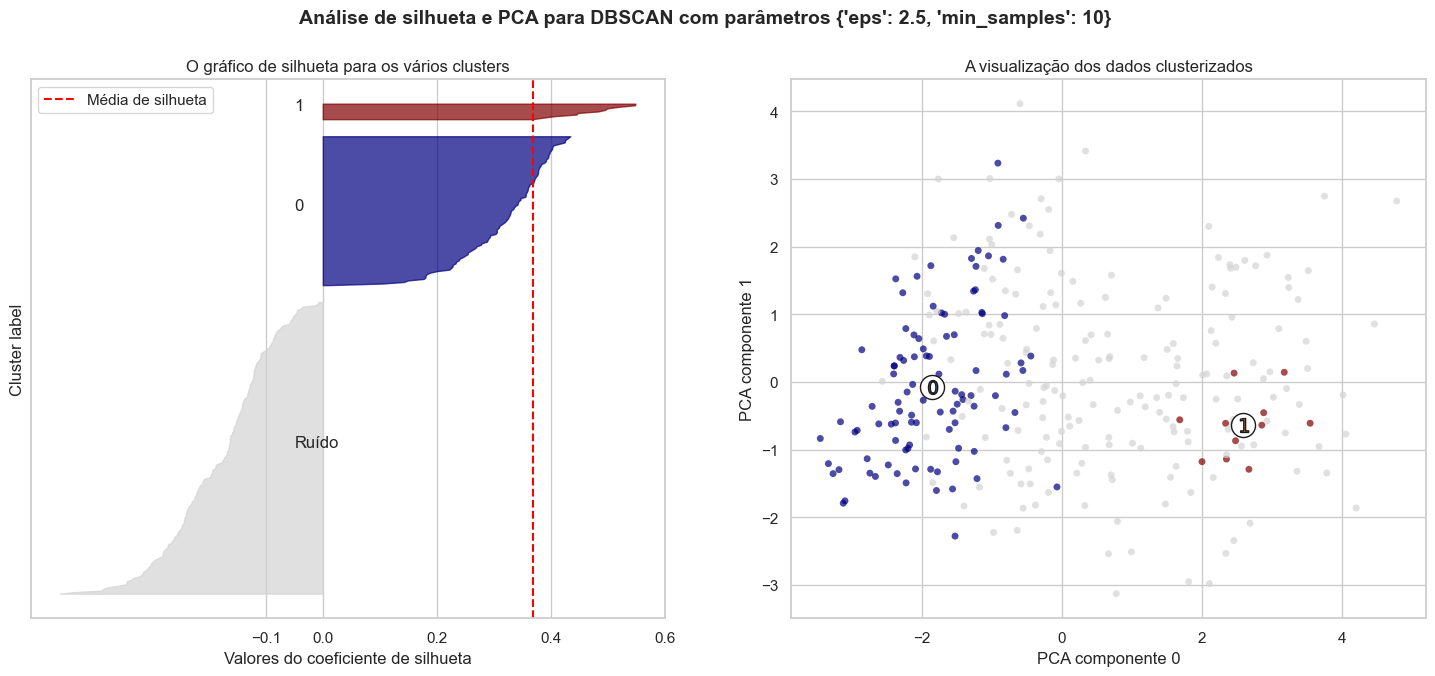

Média do coeficiente de silhueta: 0.24436710656573968


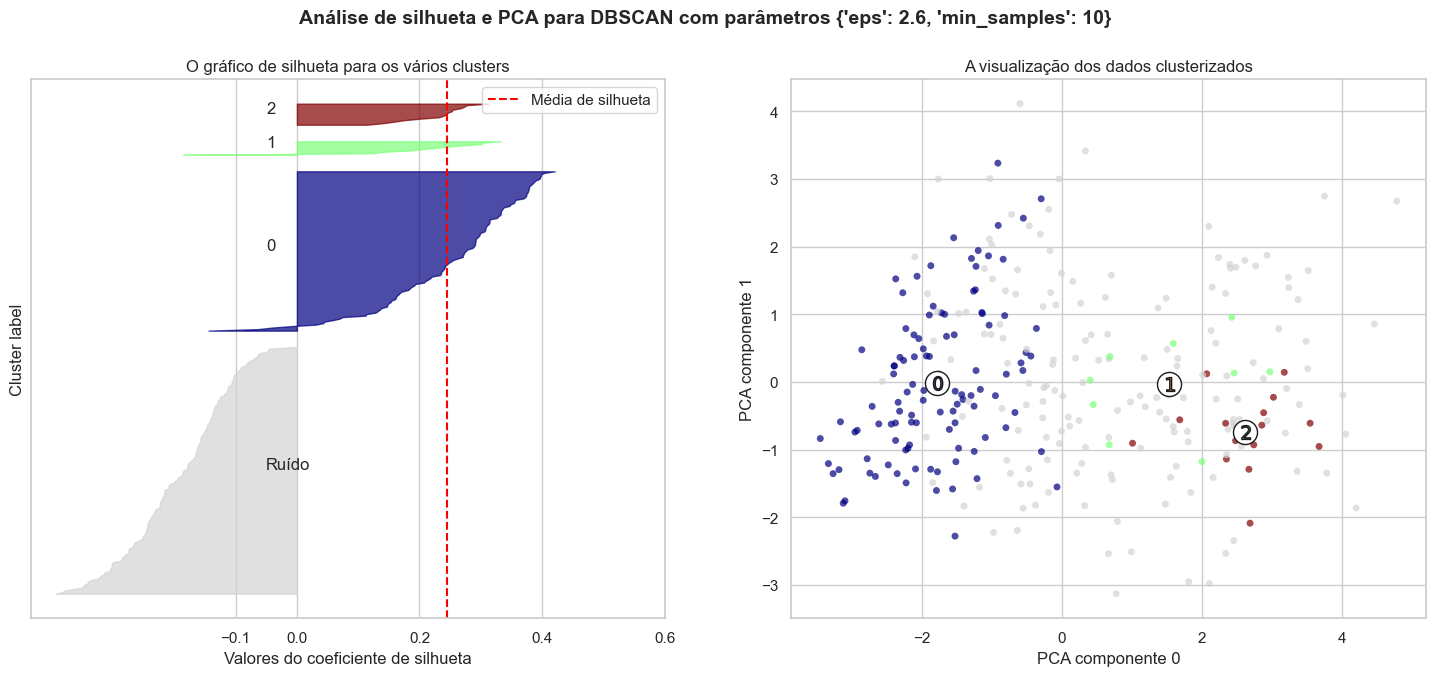

Score de silhueta não calculada: menos de 2 clusters detectados.


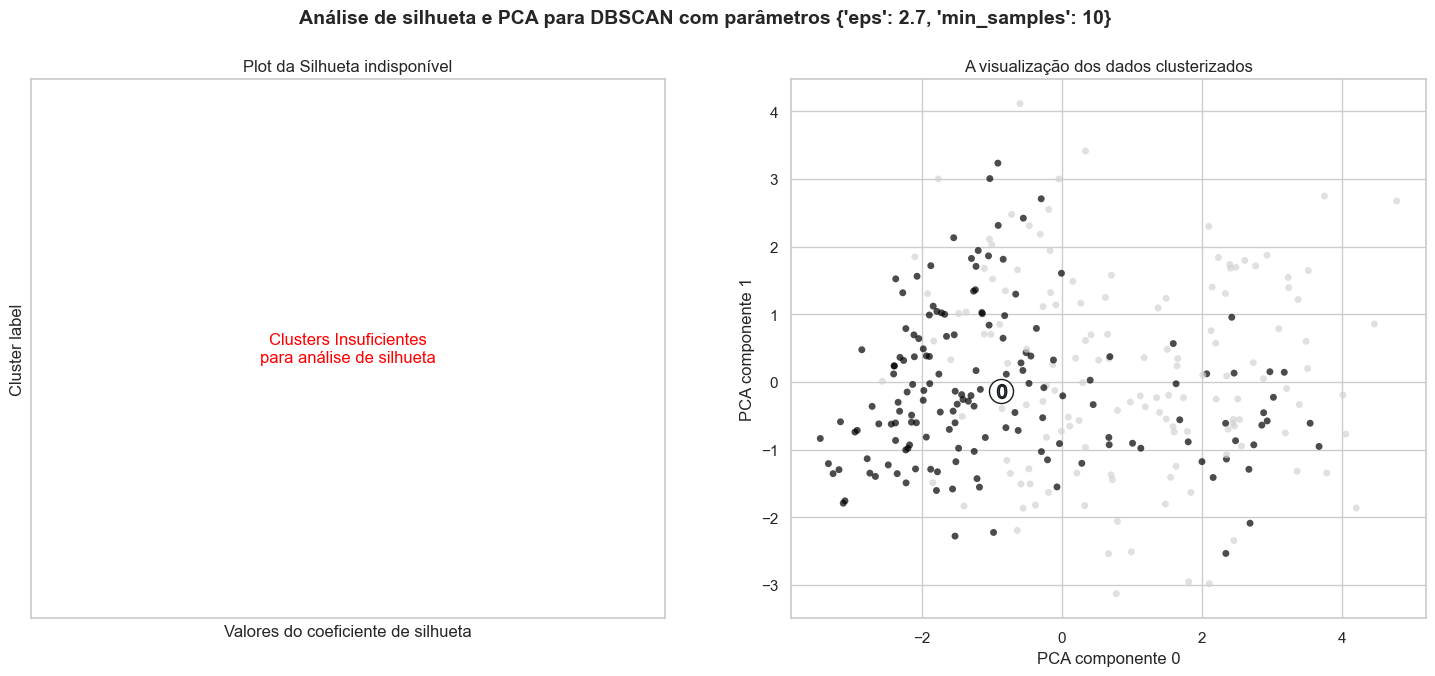

In [16]:
eps_samples_values = [
    {"eps": 2.0, "min_samples": 10},
    {"eps": 2.1, "min_samples": 10},
    {"eps": 2.2, "min_samples": 10},
    {"eps": 2.3, "min_samples": 10},
    {"eps": 2.4, "min_samples": 10},
    {"eps": 2.5, "min_samples": 10},
    {"eps": 2.6, "min_samples": 10},
    {"eps": 2.7, "min_samples": 10},
]
cluster_analysis(
    X=X_std,
    params_list=eps_samples_values,
    PCA_solver=PCA_2c,
    cluster_algo=DBSCAN
)

By the average silhouette coefficient, the best clustering was the one with densities defined by min_samples=10 and eps=2.4. However, it is important to consider the size of the clusters and the number of noises that the algorithm observed.  
In this case, the clusters seem well defined, as the silhouette in the graph shows few points close to 0. Still, we see that one of them has few points (about 10) and the noise represents more than half of the data.  
Furthermore, these two groups also appear in KMeans, which is another indication that it might be a correct clustering, but in DBSCAN it is more selective, as there are far fewer points and the algorithm does not necessarily need to place all points in some cluster.

## AgglomerativeClustering

The following function was based on the example from [scikit-learn](https://scikit-learn.org/1.5/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)

In [17]:
def plot_dendrogram(X, params):
    """
    Fits an AgglomerativeClustering model and plots its dendrogram.
    
    Parameters:
    - X: ndarray, the dataset to cluster
    - params: dict, parameters for AgglomerativeClustering (must include 'linkage' and optionally 'n_clusters')
    """
    # Ensure compute_distances is enabled for the dendrogram
    model = AgglomerativeClustering(**params, compute_distances=True)
    model.fit(X)

    # Check if the model is fitted
    if not hasattr(model, 'children_'):
        raise ValueError("O modelo deve ser uma instância de AgglomerativeClustering ajustada.")

    # Compute the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create the linkage matrix for dendrogram
    linkage_matrix = np.column_stack([
        model.children_,
        model.distances_,
        counts
    ]).astype(float)

    # Plot the dendrogram
    plt.figure(figsize=(14, 7))
    dendrogram(linkage_matrix, truncate_mode="level", p=5)
    plt.title(f"Dendrograma (linkage: {params['linkage']}, n_clusters: {params.get('n_clusters', 'None')})")
    plt.xlabel("Índice da Amostra ou Tamanho do Cluster", fontsize=12)
    plt.ylabel("Distância", fontsize=12)
    plt.xticks(fontsize=10)
    plt.tight_layout()
    plt.show()



### Ward Linkage

Média do coeficiente de silhueta: 0.16523320064617497


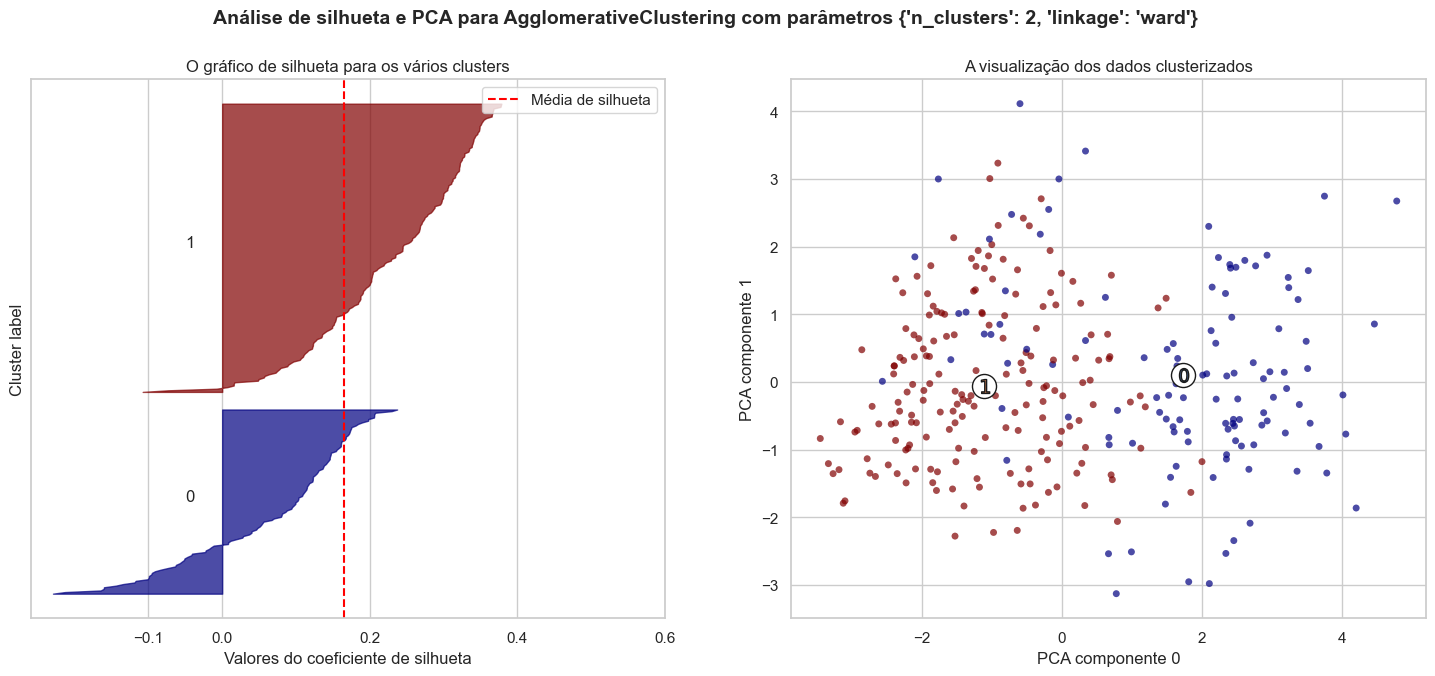

Média do coeficiente de silhueta: 0.17938839798738504


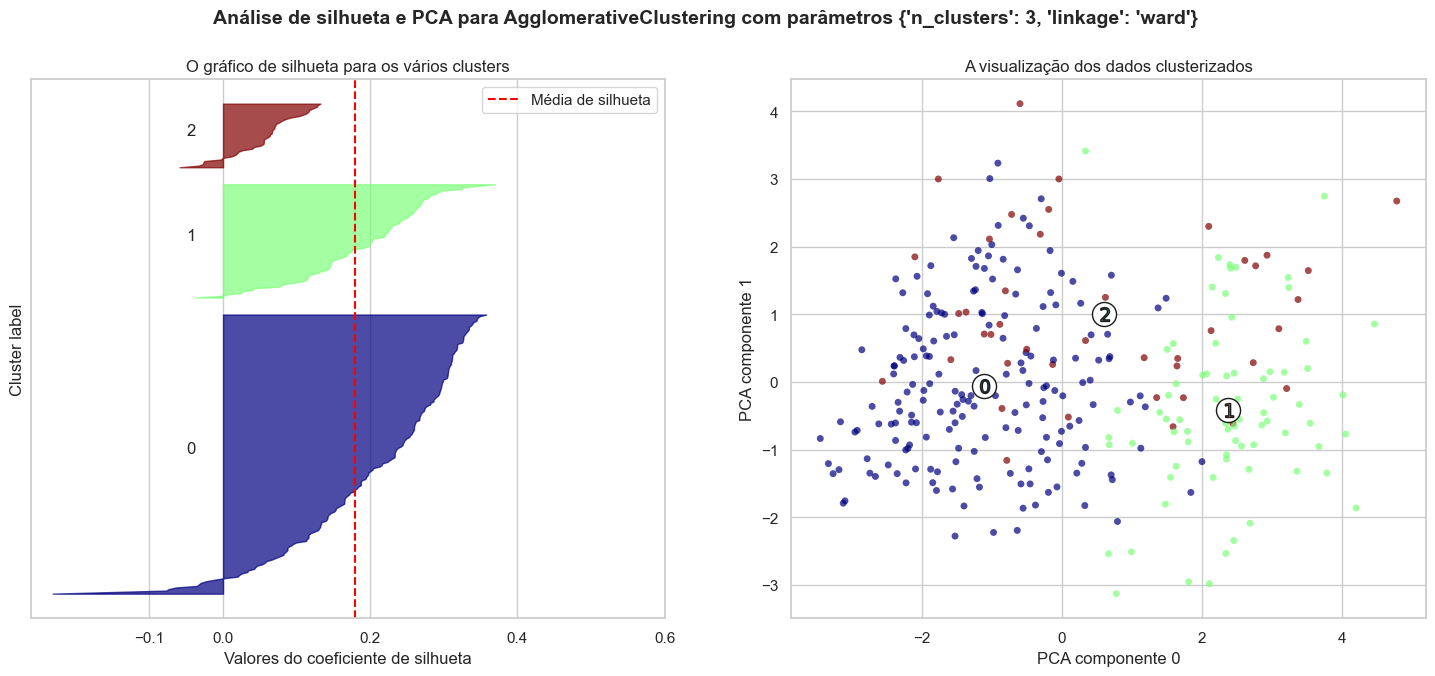

Média do coeficiente de silhueta: 0.1077177518204442


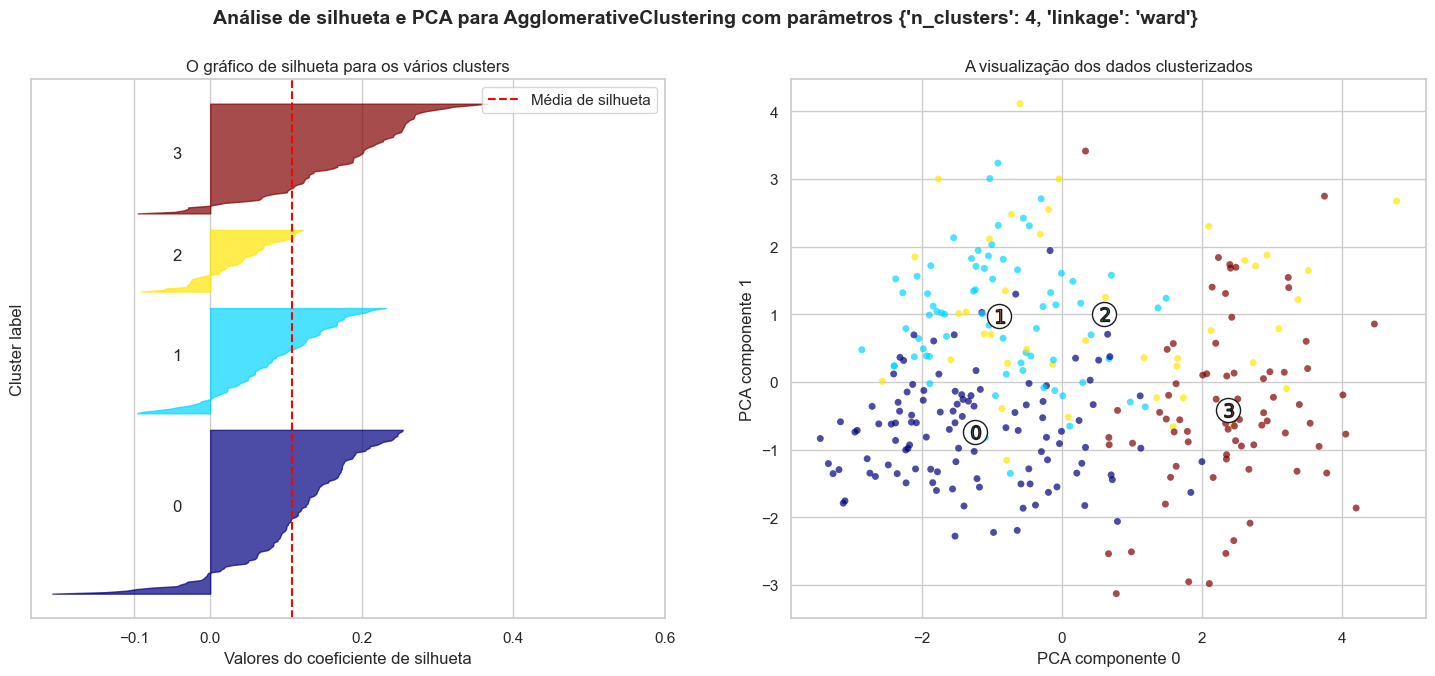

In [18]:
n_clusters_ward_values = [
    {"n_clusters": 2, "linkage": "ward"},
    {"n_clusters": 3, "linkage": "ward"},
    {"n_clusters": 4, "linkage": "ward"},
]
cluster_analysis(
    X=X_std,
    params_list=n_clusters_ward_values,
    PCA_solver=PCA_2c,
    cluster_algo=AgglomerativeClustering
)

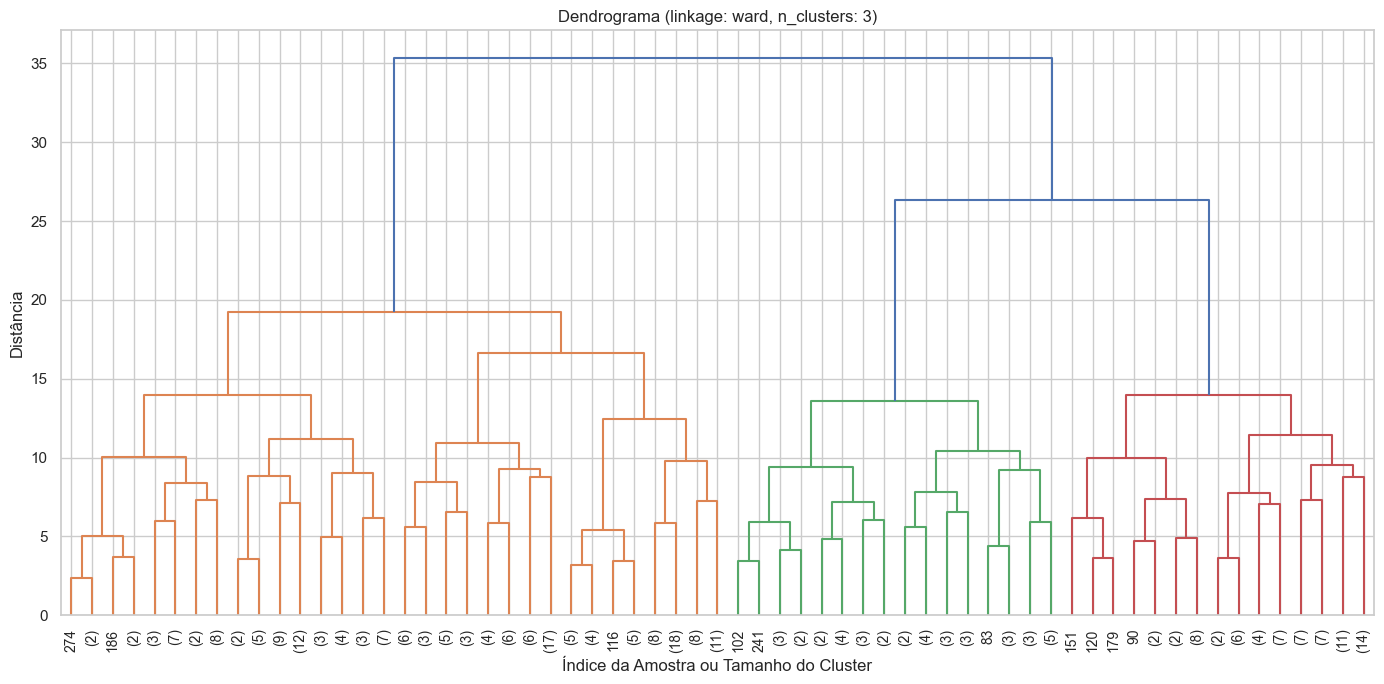

In [19]:
plot_dendrogram(X_std, {"n_clusters": 3, "linkage": "ward"})

By the silhouette, 3 clusters for the ward linkage (minimizes the variance between sets) is the best, where the dendrogram establishes distances in the same range, around [14,20].  
The PCA plot also corroborates this, as it also divides by component 0, like the previous clusterings, and by component 1. The fact that the points are not well defined in the PCA plot is a reflection of the distance calculation based on various variables and not just on diagnosis, age, and sex.

### Complete Linkage

Média do coeficiente de silhueta: 0.18837998541260206


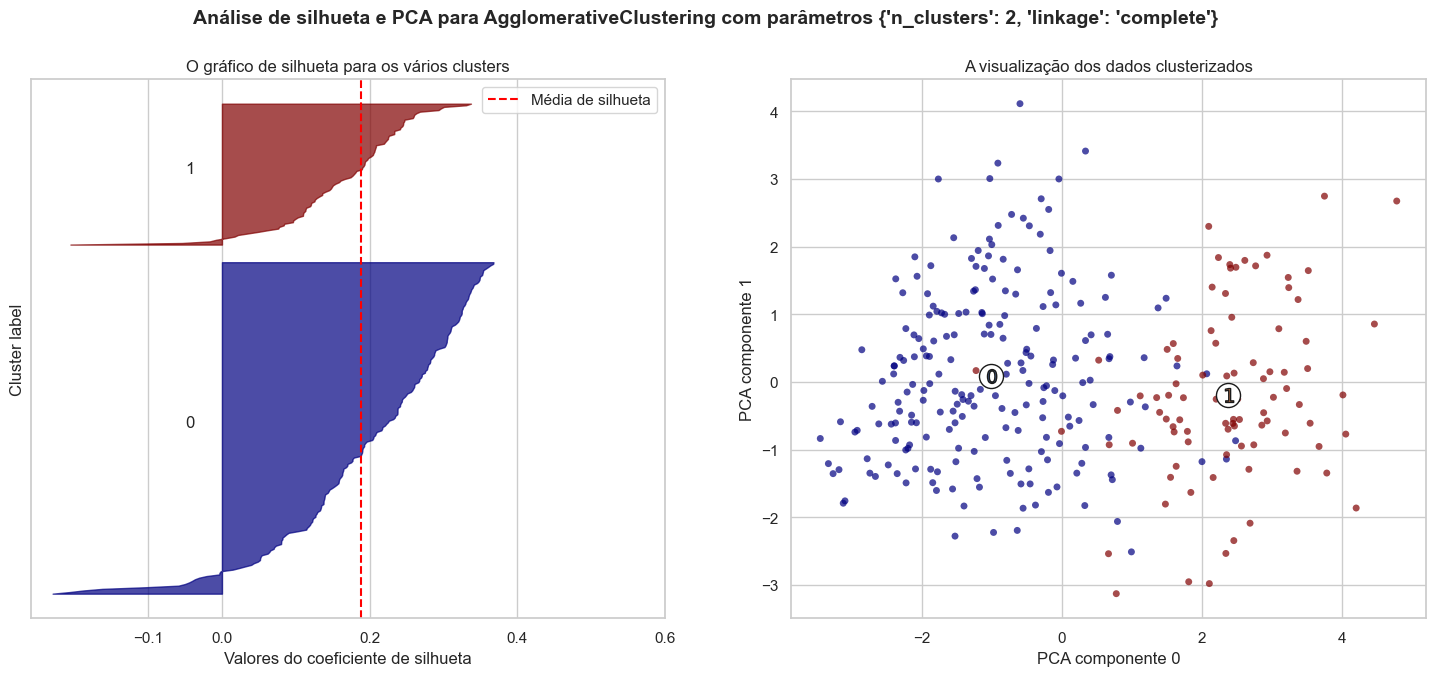

Média do coeficiente de silhueta: 0.1853531405457602


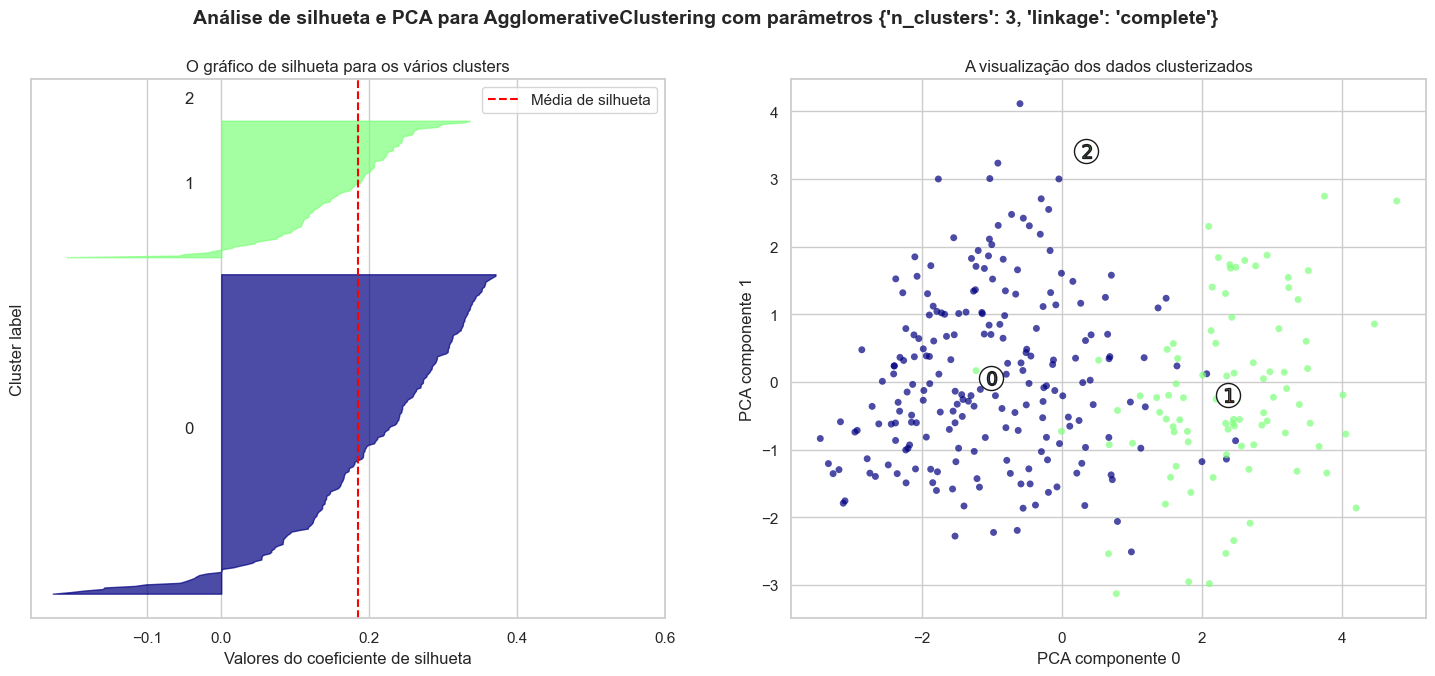

Média do coeficiente de silhueta: 0.1215940334615686


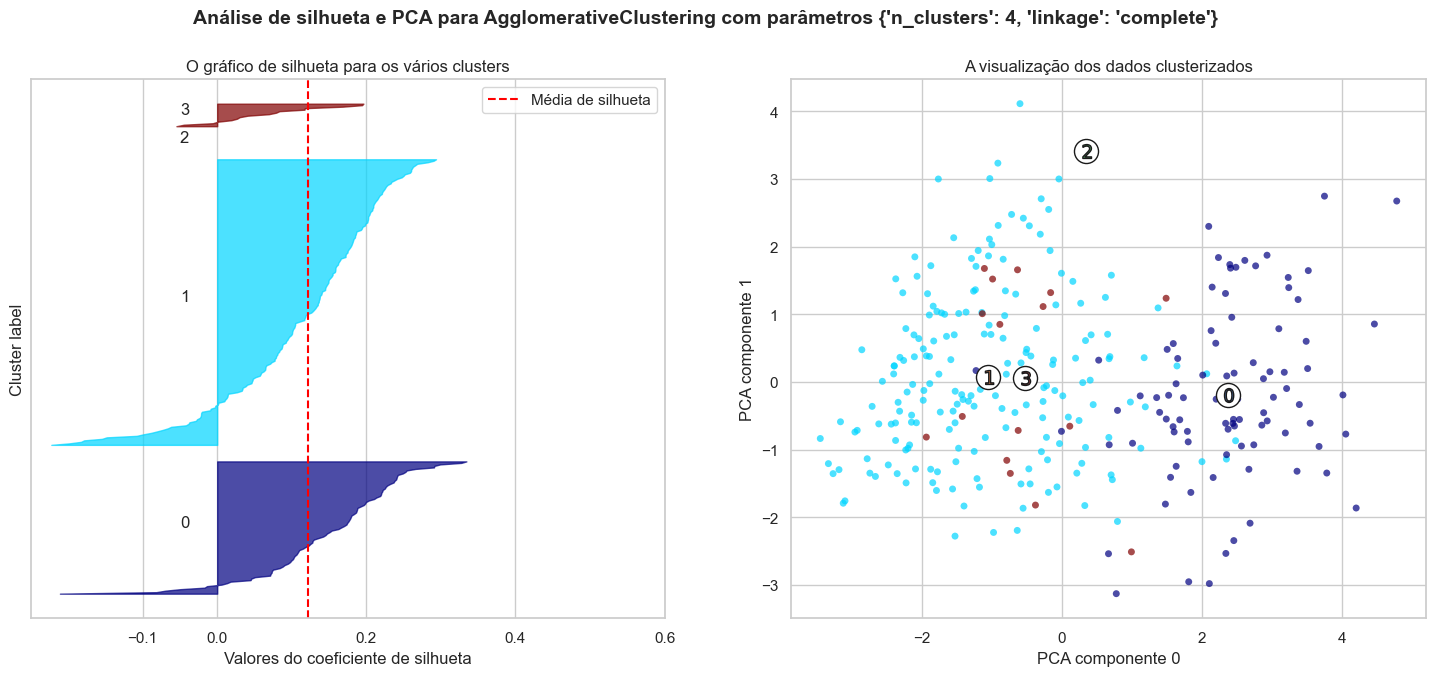

In [20]:
n_clusters_complete_values = [
    {"n_clusters": 2, "linkage": "complete"},
    {"n_clusters": 3, "linkage": "complete"},
    {"n_clusters": 4, "linkage": "complete"},
]
cluster_analysis(
    X=X_std,
    params_list=n_clusters_complete_values,
    PCA_solver=PCA_2c,
    cluster_algo=AgglomerativeClustering
)

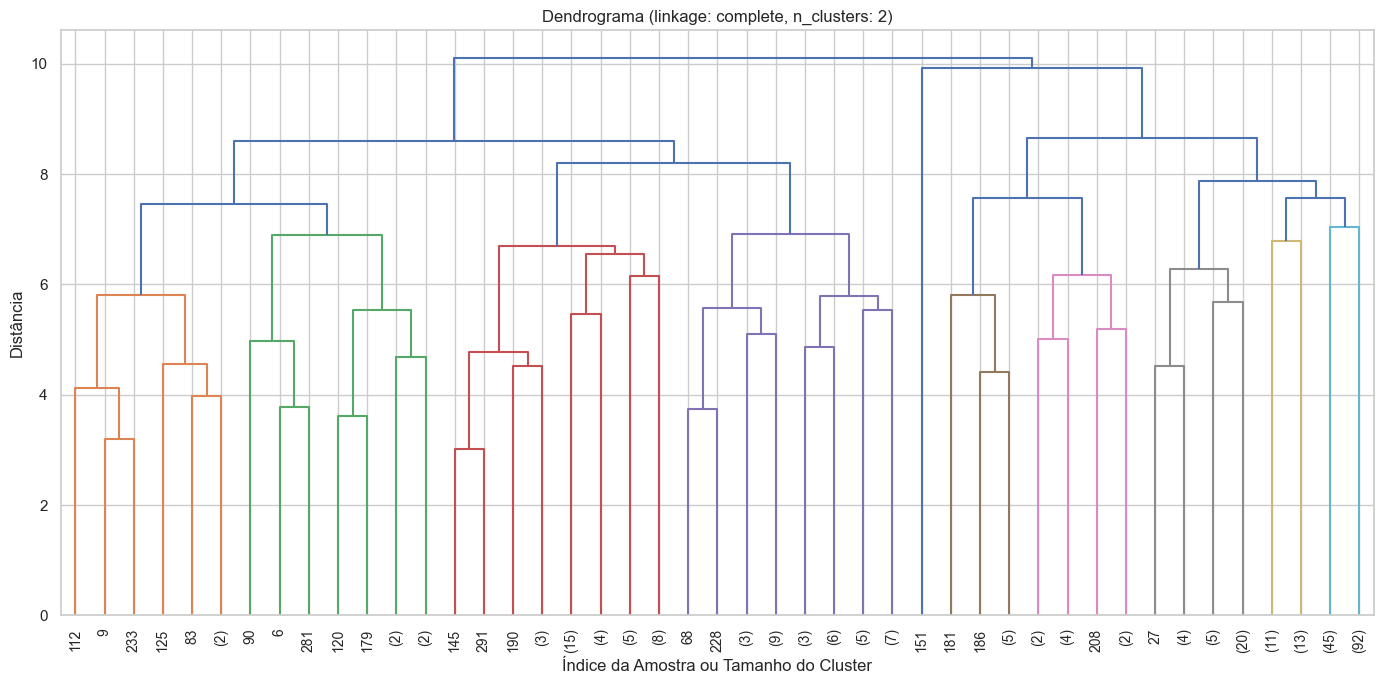

In [21]:
plot_dendrogram(X_std, {"n_clusters": 2, "linkage": "complete"})

Besides the silhouette, 2 clusters work better, as shown by the dendrogram, the sets merge between 8 and 10.5.  
3 clusters suffer from the problem of the sample with index 151, which is only joined to any cluster when considering distance 10. The PCA plot also points this out, as there is only one point for cluster 2.  
By PCA, the main difference occurs when n_clusters=2 is in component 0, that is, in the diagnosis.

### Average Linkage

Média do coeficiente de silhueta: 0.3309188172656989


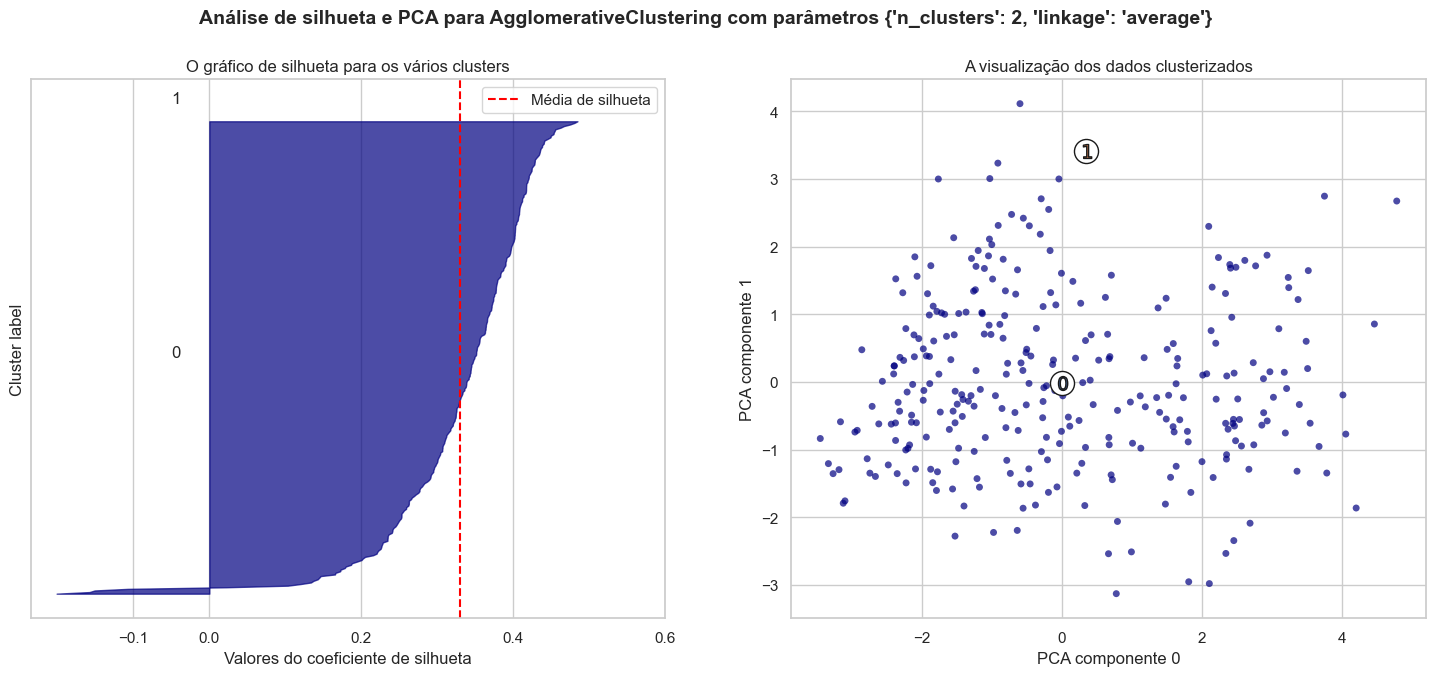

Média do coeficiente de silhueta: 0.1819295342269603


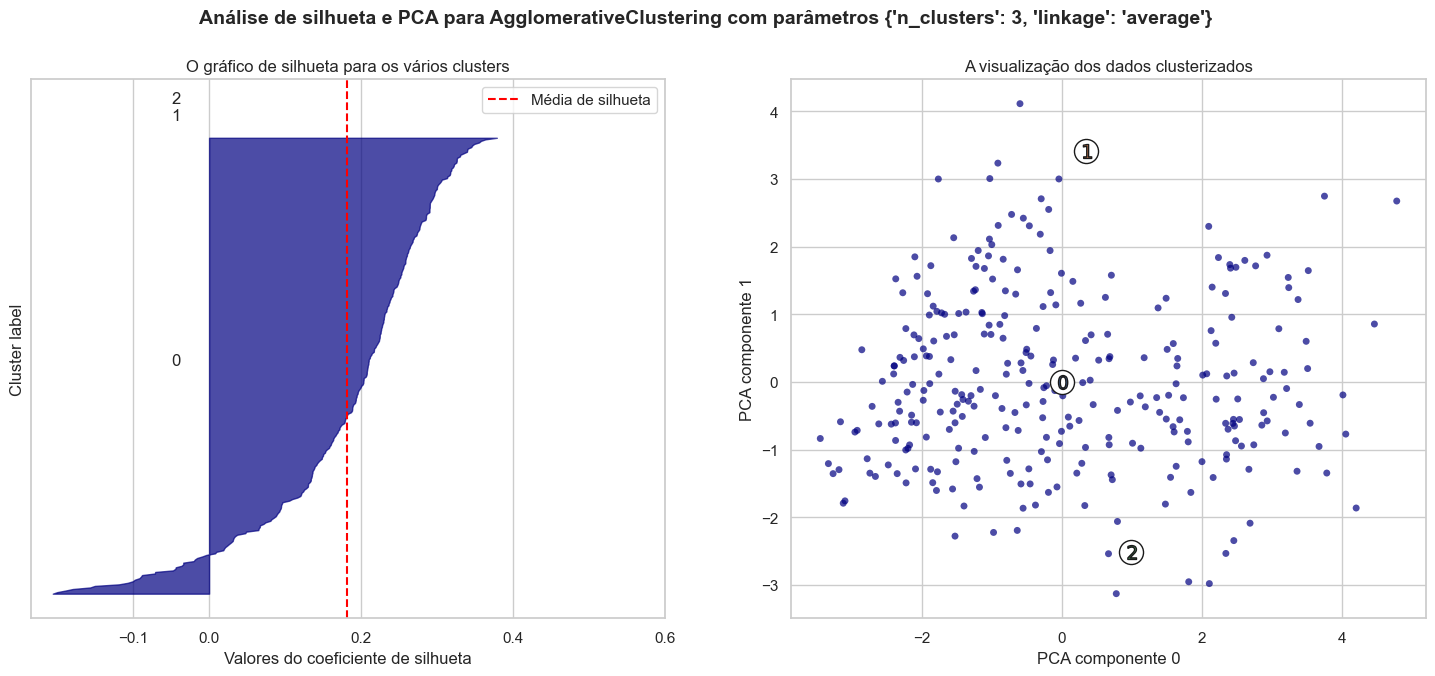

Média do coeficiente de silhueta: 0.12998654844451268


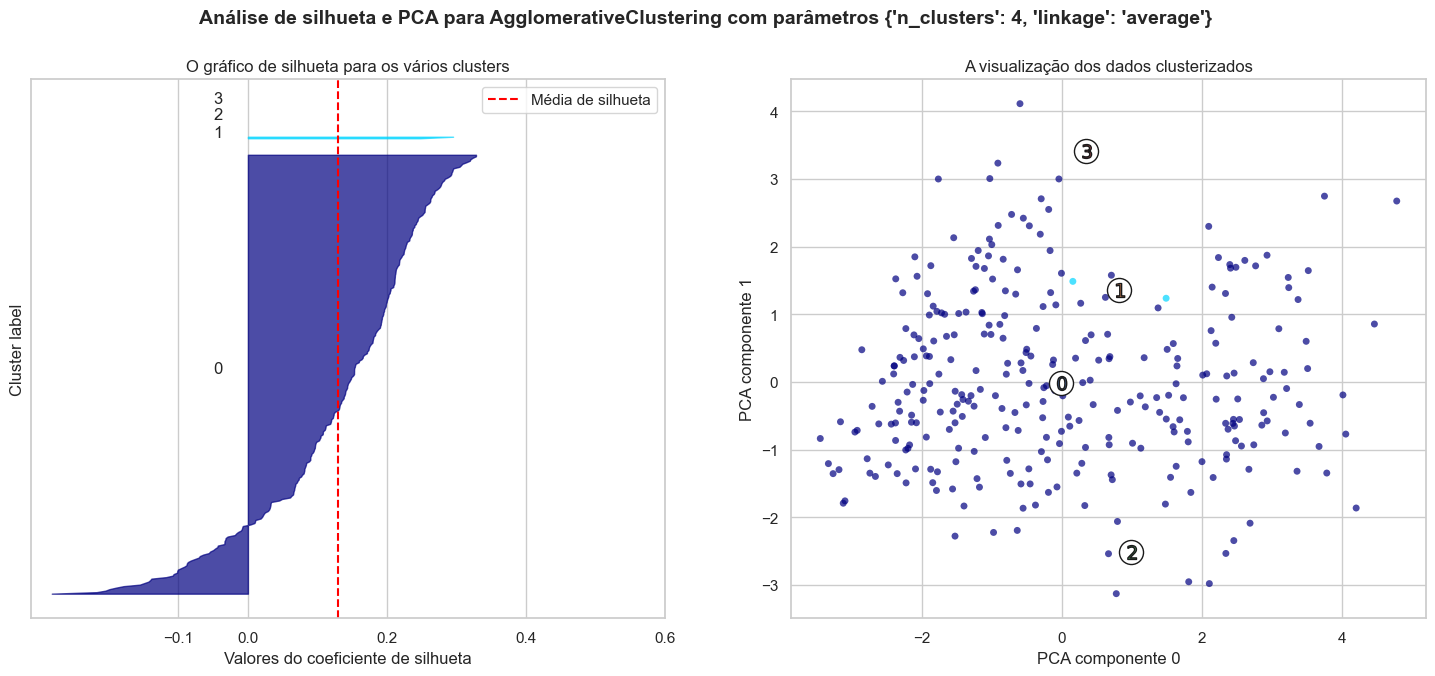

In [22]:
n_clusters_average_values = [
    {"n_clusters": 2, "linkage": "average"},
    {"n_clusters": 3, "linkage": "average"},
    {"n_clusters": 4, "linkage": "average"},
]
cluster_analysis(
    X=X_std,
    params_list=n_clusters_average_values,
    PCA_solver=PCA_2c,
    cluster_algo=AgglomerativeClustering
)

It is possible to see that Average Linkage did not perform very well, as most of the data is classified in a single cluster.

### Single Linkage

Média do coeficiente de silhueta: 0.19674723681946515


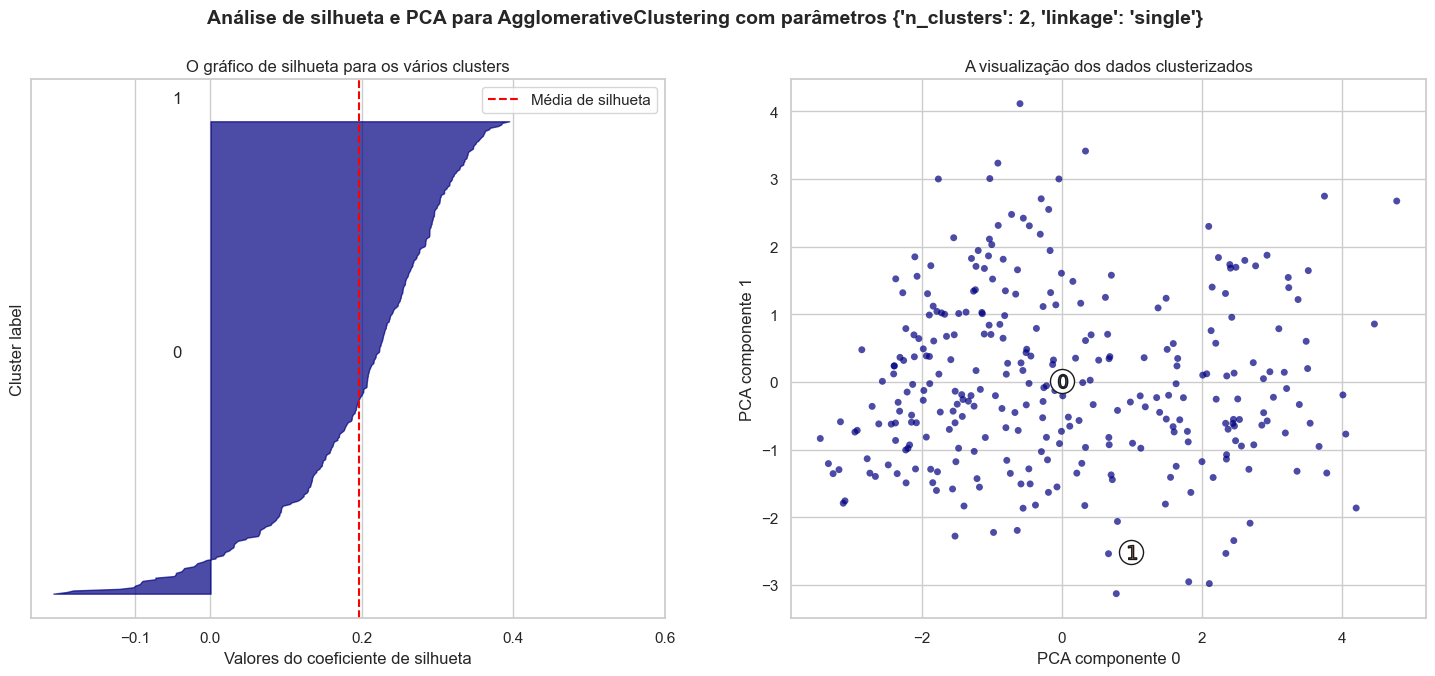

Média do coeficiente de silhueta: 0.1819295342269603


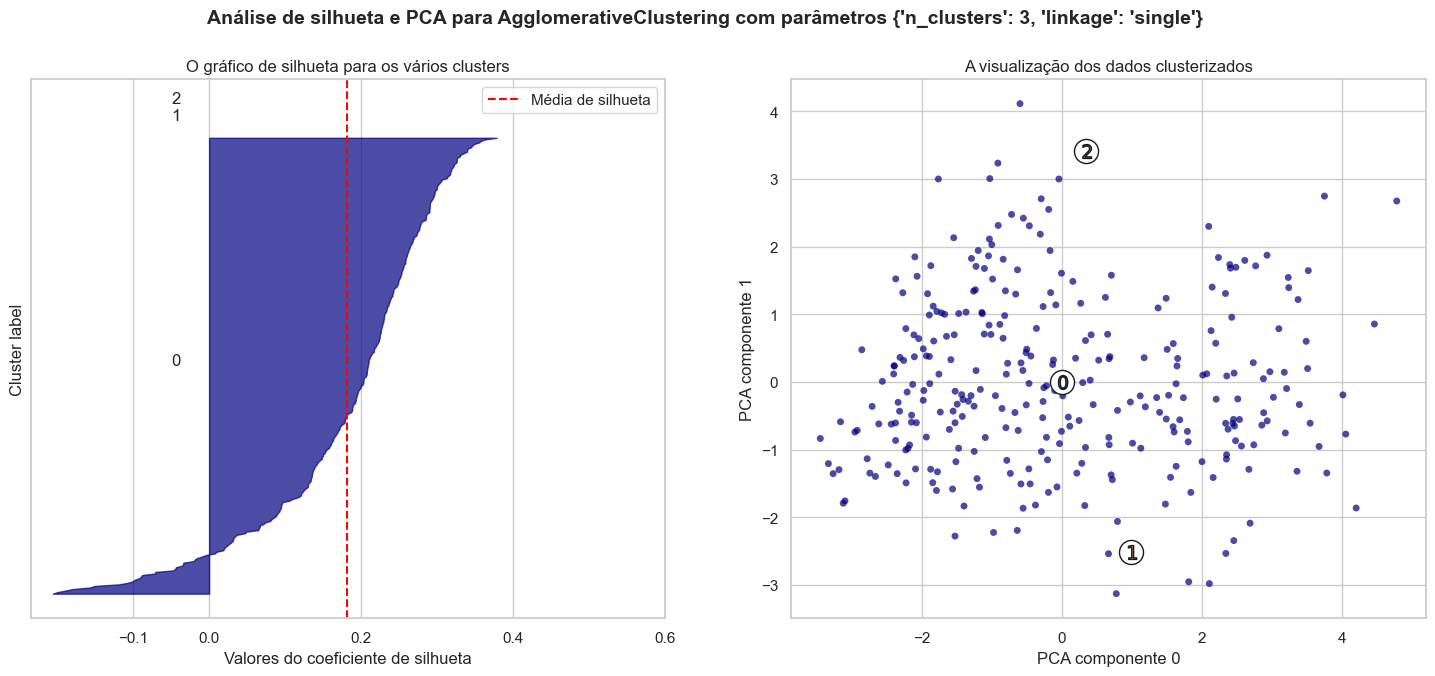

Média do coeficiente de silhueta: 0.16602039225182463


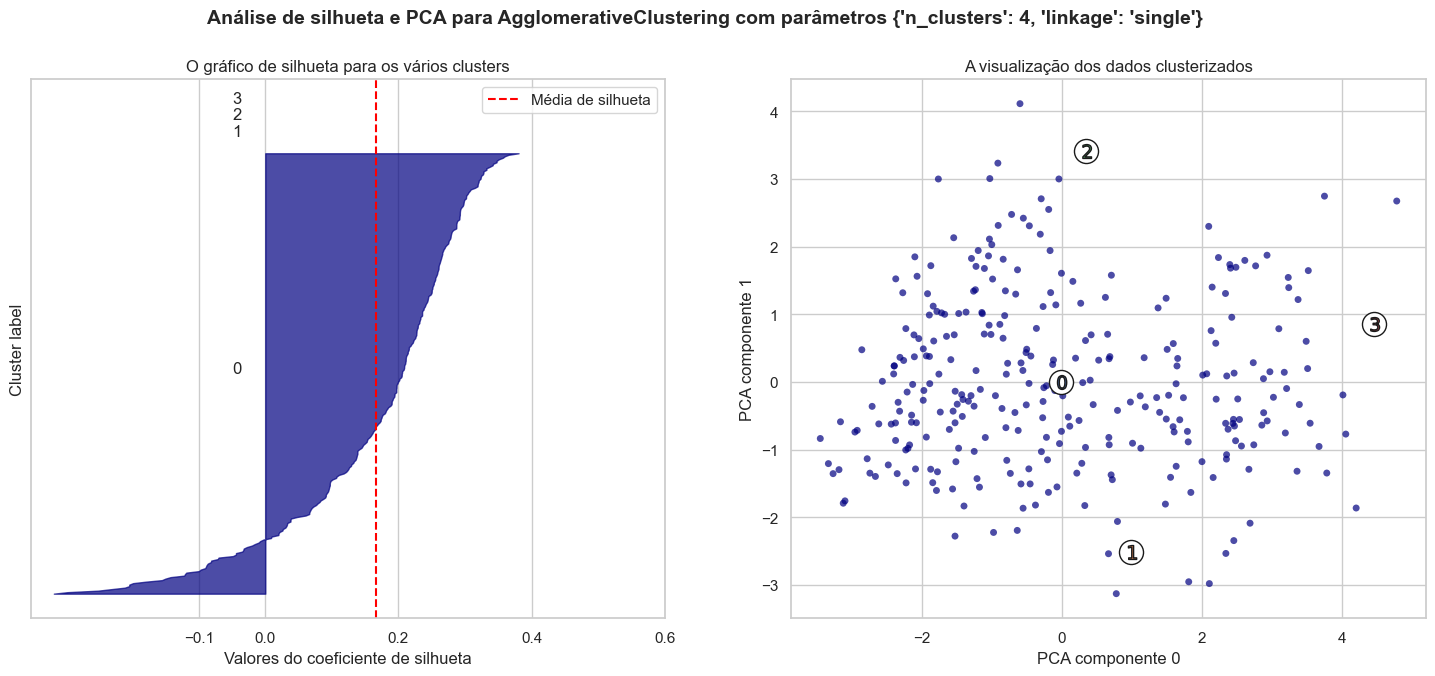

In [23]:
n_clusters_single_values = [
    {"n_clusters": 2, "linkage": "single"},
    {"n_clusters": 3, "linkage": "single"},
    {"n_clusters": 4, "linkage": "single"},
]
cluster_analysis(
    X=X_std,
    params_list=n_clusters_single_values,
    PCA_solver=PCA_2c,
    cluster_algo=AgglomerativeClustering
)

The same problem as Average, most of the data classified in a single cluster.

# Conclusion

In general, the good clusters of these three algorithms focus on the diagnosis, with the hierarchical algorithm also taking into account age and sex.  
Because of this and the way the algorithms work, a good number of clusters seems to be 2, something very well represented by KMeans, which is a very well-established method for clustering.  
If the classification of all data was not necessary, the most suitable would be the 2 clusters presented by DBSCAN, as these seem very well defined, with the caveat of having many data points not belonging to any group.  